In [69]:
import torch
import json

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [71]:
df['next_day'] = df['Receipt_Count'].shift(-1)

In [72]:
df.head()

,# Date,Receipt_Count,next_day,day,percent_change
0,2021-01-01,7564766,7455524.0,1,-0.014441
1,2021-01-02,7455524,7095414.0,2,-0.048301
2,2021-01-03,7095414,7666163.0,3,0.080439
3,2021-01-04,7666163,7771289.0,4,0.013713
4,2021-01-05,7771289,7473320.0,5,-0.038342


In [73]:
df['day'] = list(range(1, len(df)+1))

In [74]:
df.head()

,# Date,Receipt_Count,next_day,day,percent_change
0,2021-01-01,7564766,7455524.0,1,-0.014441
1,2021-01-02,7455524,7095414.0,2,-0.048301
2,2021-01-03,7095414,7666163.0,3,0.080439
3,2021-01-04,7666163,7771289.0,4,0.013713
4,2021-01-05,7771289,7473320.0,5,-0.038342


In [75]:
df['percent_change'] = df['next_day']/df['Receipt_Count'] - 1

In [76]:
df.head()

,# Date,Receipt_Count,next_day,day,percent_change
0,2021-01-01,7564766,7455524.0,1,-0.014441
1,2021-01-02,7455524,7095414.0,2,-0.048301
2,2021-01-03,7095414,7666163.0,3,0.080439
3,2021-01-04,7666163,7771289.0,4,0.013713
4,2021-01-05,7771289,7473320.0,5,-0.038342


In [77]:
df.isna().any()

# Date            False
Receipt_Count     False
next_day           True
day               False
percent_change     True
dtype: bool

In [78]:
df.dropna(inplace=True)

In [79]:
df.isna().any()

# Date            False
Receipt_Count     False
next_day          False
day               False
percent_change    False
dtype: bool

In [124]:
x, y = df['day'].values, df['percent_change'].values

In [127]:
np.savetxt('percent.txt', y)

In [81]:
def create_dataset(x, y, window=1):
    features, targets = [], []
    for i in range(len(x) - window):
        v = y[i:(i + window)]
        features.append(v)
        targets.append(y[i + window])
    return torch.tensor(np.array(features)), torch.tensor(np.array(targets))

In [82]:
window_size = 30 
x, y = create_dataset(x,y,window_size)

In [83]:
x = x.float()
y = y.float()

In [84]:
limit = int(round(len(x)*0.80))
x_train, y_train = x[:limit], y[:limit]
x_test, y_test = x[limit:], y[limit:]

In [85]:
x_train = x_train.view(-1, window_size, 1)
x_test = x_test.view(-1, window_size, 1)

In [86]:
x_test.shape

torch.Size([67, 30, 1])

In [87]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([266, 30, 1]) torch.Size([266])
torch.Size([67, 30, 1]) torch.Size([67])


In [88]:
class Receipt_Predictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Receipt_Predictor, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dense = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x,_ = self.lstm3(x)
        x = self.dense(x[:, -1, :])  # Select the last time step output
        return x

In [96]:
input_size = 1  #only one feature
hidden_size = 64
output_size = 1 #only one target
model = Receipt_Predictor(input_size, hidden_size, output_size)

In [97]:
batch_size = 128
lr = 1e-3
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [98]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [99]:
num_epochs = 1000
early_stopping_patience = 10
best_val_loss = float('inf')
counter_early_stop = 0

In [100]:
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))  # Reshape targets for the loss calculation
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, targets.view(-1, 1)).item()  # Reshape targets for the loss calculation

    val_loss /= len(val_loader)

    train_loss_history.append(loss.item())
    val_loss_history.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter_early_stop = 0
    else:
        counter_early_stop += 1
        if counter_early_stop >= early_stopping_patience:
            print("Early stopping.")
            break

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch [1/1000], Loss: 0.0175, Val Loss: 0.0119
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced 

In [103]:
loss_history = {'train' : train_loss_history, 'val' : val_loss_history }
with open('loss_history.json', 'w') as outfile:
    json.dump(loss_history, outfile)

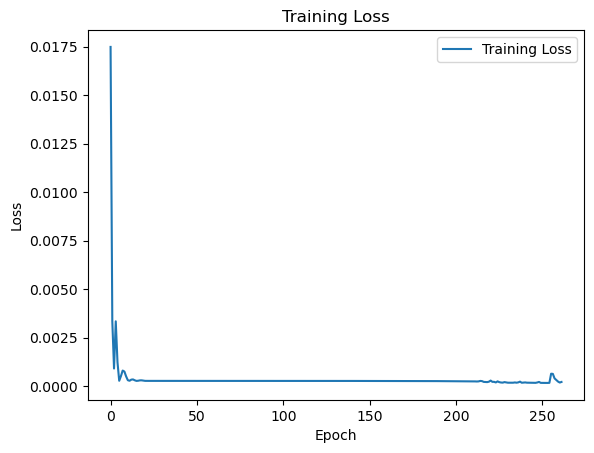

In [104]:
plt.plot(train_loss_history)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='best')
plt.show()

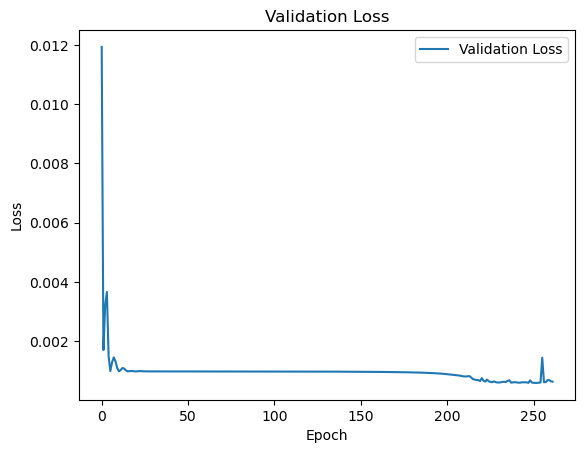

In [105]:
plt.plot(val_loss_history)
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation Loss'], loc='best')
plt.show()

In [106]:
model.eval()
y_pred = []

with torch.no_grad():
    for inputs, _ in val_loader: 
        outputs = model(inputs)
        y_pred.extend(outputs.view(-1).numpy())

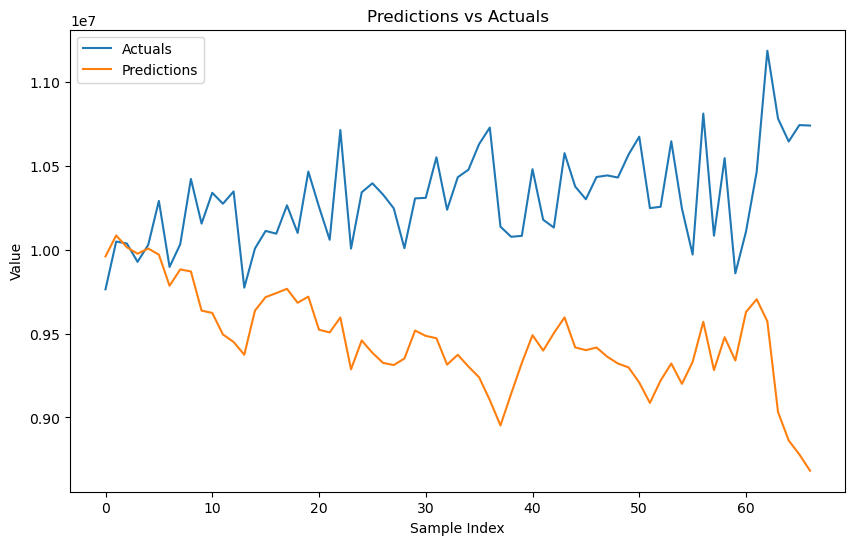

In [107]:

# Post-process predictions
preds = []
actuals = []
start = df['Receipt_Count'].values[limit]

for i, p in enumerate(y_pred):
    if preds == []:
        preds.append((1 + p) * start)
        actuals.append((1+y_test[i]) * start)
    else:
        preds.append((1 + p) * preds[-1])
        actuals.append((1+y_test[i]) * actuals[-1])

# Plotting predictions vs actuals
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actuals')
plt.plot(preds, label='Predictions')
plt.title('Predictions vs Actuals')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

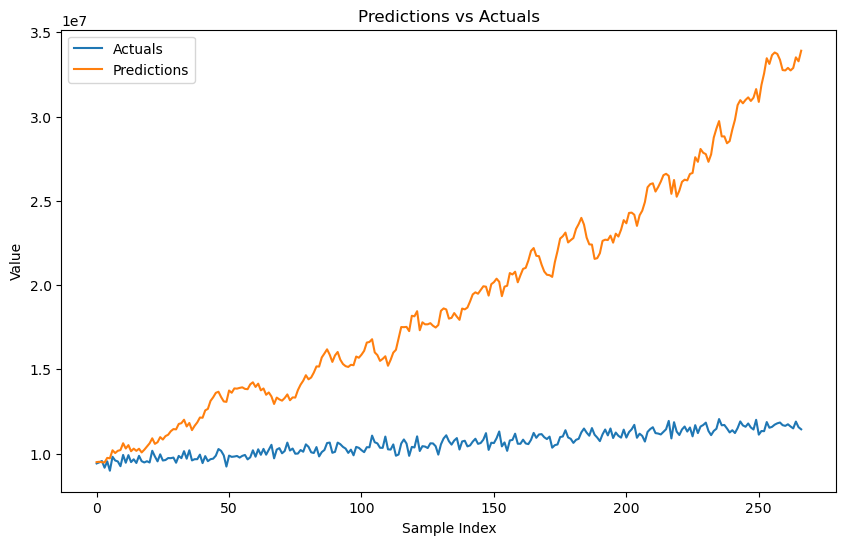

In [65]:

y_pred = []
with torch.no_grad():
    for inputs, _ in train_loader:  # Note: Use val_loader for predictions on the test set
        outputs = model(inputs)
        y_pred.extend(outputs.view(-1).numpy())
preds = []
actuals = []
start = df['Receipt_Count'].values[limit]

for i, p in enumerate(y_pred):
    if preds == []:
        preds.append((1 + p) * start)
        actuals.append((1+y_train[i]) * start)
    else:
        preds.append((1 + p) * preds[-1])
        actuals.append((1+y_train[i]) * actuals[-1])

# Plotting predictions vs actuals
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actuals')
plt.plot(preds, label='Predictions')
plt.title('Predictions vs Actuals')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [118]:
num_future_steps = 365
predictions = []
current_input = y[-window_size:]

# Convert the PyTorch model to evaluation mode
model.eval()

for i in range(num_future_steps):
    # Convert current_input to PyTorch tensor
    current_input_tensor = torch.Tensor(current_input).view(1, window_size, 1)

    # Use the model to make a prediction
    with torch.no_grad():
        current_prediction = model(current_input_tensor)

    # Convert the prediction to a NumPy array
    current_prediction = current_prediction.view(-1).numpy()
    
    predictions.append(current_prediction)

    # Update current_input for the next iteration
    current_input = np.append(current_input, predictions[-1])
    current_input = current_input[-window_size:]

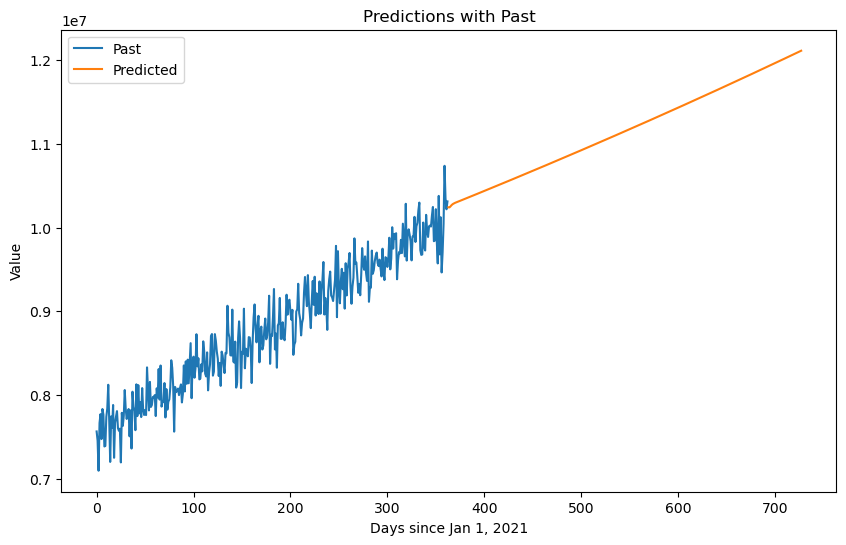

In [121]:
preds = [] 
firstPreds = df['Receipt_Count'].values.tolist()
for i,p in enumerate(predictions):
	if i == 0: preds.append((1+p)*firstPreds[-1])
	else: preds.append((1+p)*preds[-1])
indices = range(len(firstPreds)+len(preds))
plt.figure(figsize=(10,6))
plt.plot(indices[:len(firstPreds)], firstPreds, label='Past')
plt.plot(indices[len(firstPreds):], preds, label='Predicted')
plt.title('Predictions with Past')
plt.xlabel('Days since Jan 1, 2021')
plt.ylabel('Value')
plt.legend()
plt.show()

In [122]:
torch.save(model.state_dict(), 'lstm_weights.pt')